In [1]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.nn import MSELoss
from src.spaces.hyperbolic import HyperbolicSpace
from src.spectral_kernel import RandomSpectralKernel, RandomFourierFeatureKernel
from src.prior_approximation import RandomFourierApproximation
from src.spectral_measure import MaternSpectralMeasure, SqExpSpectralMeasure
from examples.gpr_model import ExactGPModel, train
import matplotlib.pyplot as plt
import gpytorch
import os
import sys

INFO: Using numpy backend


In [2]:
sys.setrecursionlimit(2000)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.autograd.set_detect_anomaly(True)
dtype = torch.float64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
order = 10**3
space = HyperbolicSpace(n=2, order=order)

In [4]:
def plot_disc(x, y):
    fig, ax = plt.subplots()
    plt.scatter(x.detach().cpu()[:, 0], x.detach().cpu()[:, 1], c=y.detach().cpu())
    circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="black")
    ax.add_patch(circle)
    plt.show()

In [5]:
def f(x):
    x_norm = x/torch.norm(x, dim=1, keepdim=True)
    angle_ = torch.arccos(x_norm[:, 0])
    return torch.sin(2*space._dist_to_id(x)+2*angle_)
    #return 1/(1 + torch.square(space._dist_to_id(x)))


lspace = torch.linspace(-1, 1, 50, device=device, dtype=dtype)
test_x = torch.cartesian_prod(lspace, lspace)
test_x = test_x[torch.norm(test_x, dim=1) < 0.99]

train_x = space.rand(200)
train_y, test_y = f(train_x), f(test_x)
print("test variance: ", torch.var(test_y))

test variance:  tensor(0.5054, device='cuda:0', dtype=torch.float64)


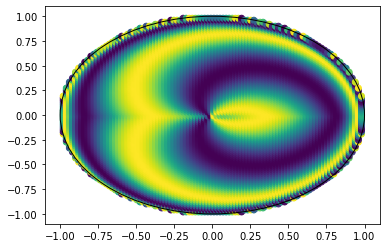

In [6]:
lspace = torch.linspace(-1, 1, 100, device='cpu', dtype=dtype)
x = torch.cartesian_prod(lspace, lspace)
x = x[torch.norm(x, dim=1) < 1]
plot_disc(x, f(x))

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
euclidean_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
euclidean_model = ExactGPModel(train_x, train_y, likelihood, euclidean_kernel, space).to(device=device)
train(euclidean_model, train_x, train_y)

C:\Users\Iskander\anaconda3\envs\geomkernel\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 300/900 - Loss: 0.529   lengthscale: 0.132 variance: 0.492   noise: 0.037
Iter 600/900 - Loss: 0.529   lengthscale: 0.132 variance: 0.492   noise: 0.037
Iter 900/900 - Loss: 0.529   lengthscale: 0.132 variance: 0.492   noise: 0.037


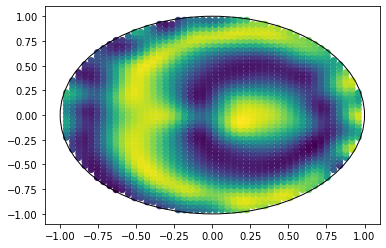

euclidean error: tensor(0.1440, dtype=torch.float64)


In [8]:
euclidean_model.eval()
with torch.no_grad(), gpytorch.settings.skip_posterior_variances(state=True):
    euclidean_f = euclidean_model(test_x)
euclidean_pred_y = euclidean_f.mean
plot_disc(test_x, euclidean_pred_y)
error = MSELoss()(euclidean_pred_y, test_y)
print("euclidean error:", error.detach().cpu())

In [9]:
lengthscale, nu, variance = 1, 2.0 + space.dim, 2.0
measure = SqExpSpectralMeasure(space.dim, lengthscale, variance=variance)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
geometric_kernel = RandomFourierFeatureKernel(measure, space)
geometric_model = ExactGPModel(train_x, train_y, likelihood, geometric_kernel, space).to(device=device)
train(geometric_model, train_x, train_y)

Iter 300/900 - Loss: 0.484   lengthscale: 0.754 variance: 0.462   noise: 0.024
Iter 600/900 - Loss: 0.421   lengthscale: 0.565 variance: 0.452   noise: 0.022
Iter 900/900 - Loss: 0.432   lengthscale: 0.530 variance: 0.450   noise: 0.022


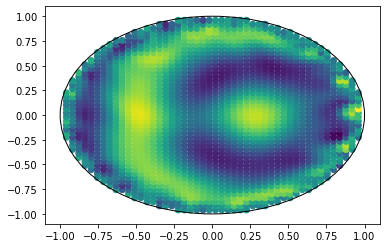

geometric heat kernel error: tensor(0.1027, dtype=torch.float64)


In [10]:
geometric_model.eval()
with torch.no_grad(), gpytorch.settings.skip_posterior_variances(state=True):
    euclidean_f = geometric_model(test_x)
geometric_f = geometric_model(test_x)
geometric_pred_y = geometric_f.mean
plot_disc(test_x, geometric_pred_y)
error = MSELoss()(geometric_pred_y, test_y)
print("geometric heat kernel error:", error.detach().cpu())

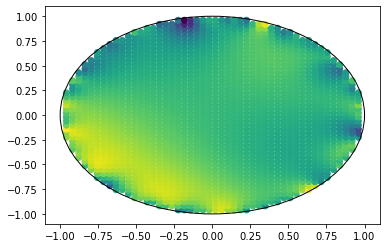

In [11]:
init_lengthscale, init_nu, init_variance = 2.0, 2.0 + space.dim, 3.0
measure = SqExpSpectralMeasure(space.dim, lengthscale=init_lengthscale, variance=init_variance)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
geometric_kernel = RandomFourierFeatureKernel(measure, space)
geometric_sampler = RandomFourierApproximation(geometric_kernel)

train_y, test_y = geometric_sampler(train_x), geometric_sampler(test_x)

plot_disc(test_x, test_y)

In [12]:
lengthscale, nu, variance = 1.0, 5.0 + space.dim, 1.0
measure = SqExpSpectralMeasure(space.dim, lengthscale, variance=variance)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
geometric_kernel = RandomFourierFeatureKernel(measure, space)
geometric_model = ExactGPModel(train_x, train_y, likelihood, geometric_kernel, space).to(device=device)
train(geometric_model, train_x, train_y)

Iter 300/900 - Loss: -1.265   lengthscale: 1.836 variance: 3.749   noise: 0.000
Iter 600/900 - Loss: -1.413   lengthscale: 1.773 variance: 3.789   noise: 0.000
Iter 900/900 - Loss: -1.389   lengthscale: 1.746 variance: 3.804   noise: 0.000


In [13]:
trained_lengthscale = geometric_model.covar_module.measure.lengthscale.item()
trained_variance = geometric_model.covar_module.measure.variance.item()
print('original: lengthscale: %.3f variance: %.3f' % (init_lengthscale, init_variance))
print('trained: lengthscale: %.3f variance: %.3f' % (trained_lengthscale,trained_variance))


original: lengthscale: 2.000 variance: 3.000
trained: lengthscale: 1.746 variance: 3.804
